**Cloud Classification**

Given a data set of pictures, this exercise has two goals:
- distinguish between pictures *with clouds* and *without clouds*
- within the pictures with clouds, distinguish between three cloud categories: *cirrus*, *cumulus*, and *lenticularis*

This will be achieved through Convolutional Neural Networks.

The data set consists of 204 photos that have been preprocessed to increase contrast and reduce size (to 800x600 pixels, grayscale) and thus computing time needed. Given that this is a very small sample, it is first necessary to do some data augmentation. To do this, I will simply crop out squares of 266x266 pixels from each photo. These will be 6 squares from photos without clouds and 3 squares from the top half of photos with clouds, because there are often no clouds in the bottom half of the pictures. Note that the pictures without clouds do not necessarily include the sky.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
## Read images into a list of arrays (X), and the labels into y
X = []
y = []
categories = ('cirrus','cumulus','lenticularis','noclouds')
for label in categories:
    files = glob.glob('../data/clouds/' + label + '*.jpg')
    for fi in files:
        image = plt.imread(fi)
        if (label == 'noclouds'):
            squares = [image[:266,:266], image[:266,266:532], image[:266,532:798],
                       image[266:532,:266], image[266:532,266:532], image[266:532,532:798]]
        else:
            squares = [image[34:300,:266], image[34:300,266:532], image[34:300,532:798]]
        for square in squares: 
            X.append(square)
            y.append(label)

In [3]:
len(X)

750

The data set is now made of 750 images, with following distribution:

<BarContainer object of 4 artists>

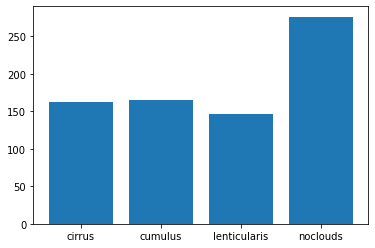

In [4]:
plt.bar(np.arange(4), [y.count(cat) for cat in categories], tick_label=categories)

Let's plot a couple of examples for each category:

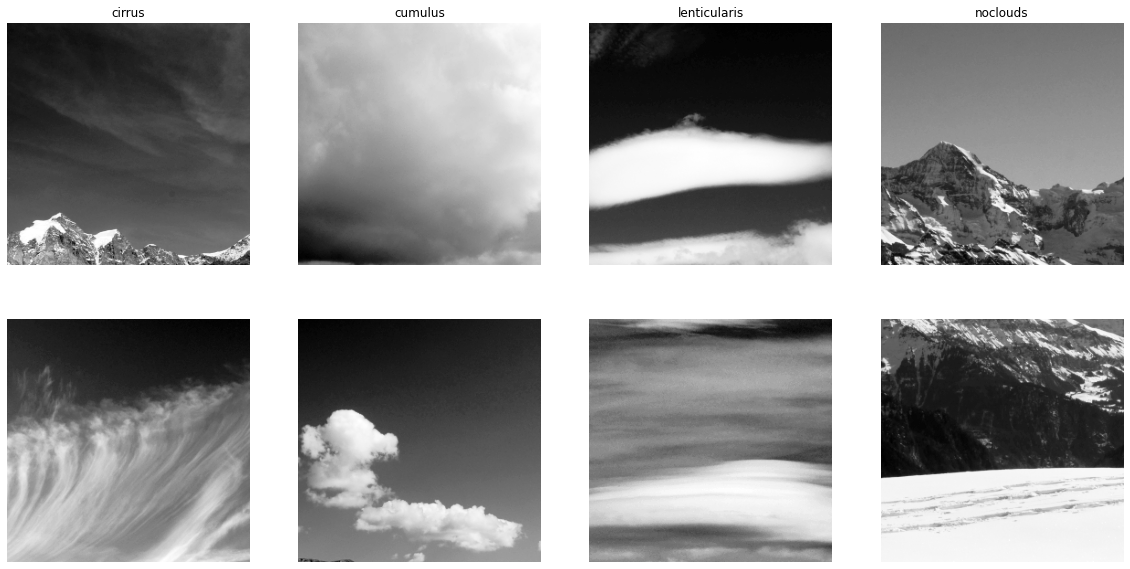

In [5]:
fig, ax = plt.subplots(2, 4)
fig.set_figwidth(20)
fig.set_figheight(10)
for i in np.arange(4):
    i_cat = y.index(categories[i])
    ax[0,i].imshow(X[i_cat+1], cmap='Greys_r')
    ax[0,i].set_title(categories[i])
    ax[0,i].axis('off')
    ax[1,i].imshow(X[i_cat+4], cmap='Greys_r')
    ax[1,i].axis('off')

**Clouds vs No clouds**

There are many more photos with clouds than without (almost double). Therefore, it is necessary to stratify training and test data accordingly. In addition, a binary label (cloud yes/no) must be created.

In [6]:
## Prepare training and test data
X = np.array(X)
X = X.astype('float32')
X /= 255
X = np.expand_dims(X, 3)
y = np.array(y)
y = LabelEncoder().fit_transform(y)
#y = keras.utils.to_categorical(y, 4)
y_binary = y.copy()
for i in np.arange(len(y)): y_binary[i] = 0 if y_binary[i] == 3 else 1
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, 
                                                    test_size=0.25, 
                                                    random_state=321, 
                                                    stratify=y_binary)

The first CNN that I will test is composed of:
- 1 convolutional layer + max pooling + dropout 25%
- 2 dense layers + dropout 25%
- final layer with sigmoid activation

In [7]:
model_1 = Sequential()

## 5x5 convolution with 2x2 stride and 16 filters
model_1.add(Conv2D(16, (5, 5), strides=(2,2),
            input_shape=X_train.shape[1:]))
model_1.add(Activation('relu'))

## 3x3 max pooling
model_1.add(MaxPooling2D(pool_size=(3, 3)))
model_1.add(Dropout(0.25))

## Two dense layers with 128 nodes
model_1.add(Flatten())
model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 131, 131, 16)      416       
_________________________________________________________________
activation (Activation)      (None, 131, 131, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 43, 43, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 29584)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3786880   
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

Train for 8 epochs with a batch size of 25:

In [8]:
model_1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])

model_1.fit(X_train, y_train,
            batch_size=25,
            epochs=8,
            validation_data=(X_test, y_test),
            shuffle=True)

Epoch 1/8
23/23 [==============================] - 6s 247ms/step - loss: 0.5452 - accuracy: 0.7438 - val_loss: 0.4233 - val_accuracy: 0.8191
Epoch 2/8
23/23 [==============================] - 5s 238ms/step - loss: 0.3703 - accuracy: 0.8630 - val_loss: 0.3132 - val_accuracy: 0.8936
Epoch 3/8
23/23 [==============================] - 5s 218ms/step - loss: 0.3207 - accuracy: 0.8861 - val_loss: 0.3031 - val_accuracy: 0.8883
Epoch 4/8
23/23 [==============================] - 5s 215ms/step - loss: 0.2910 - accuracy: 0.9021 - val_loss: 0.2841 - val_accuracy: 0.8936
Epoch 5/8
23/23 [==============================] - 5s 219ms/step - loss: 0.2737 - accuracy: 0.9004 - val_loss: 0.2719 - val_accuracy: 0.9043
Epoch 6/8
23/23 [==============================] - 5s 220ms/step - loss: 0.2650 - accuracy: 0.9075 - val_loss: 0.2854 - val_accuracy: 0.8936
Epoch 7/8
23/23 [==============================] - 5s 236ms/step - loss: 0.2666 - accuracy: 0.9110 - val_loss: 0.2960 - val_accuracy: 0.8723
Epoch 8/8
23/

The validation accuracy is close to 90%, compared to an accuracy of 63% for a random guess (because 63% of the validation images have clouds). Trying a more complex model with four convolutional layers and more, smaller kernels does not  improve the results:

In [9]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(3, 3)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(128))
model_2.add(Activation('relu'))
model_2.add(Dense(128))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 264, 264, 32)      320       
_________________________________________________________________
activation_4 (Activation)    (None, 264, 264, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 262, 262, 32)      9248      
_________________________________________________________________
activation_5 (Activation)    (None, 262, 262, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 87, 87, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 85, 85, 32)       

In [10]:
model_2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0003),
              metrics=['accuracy'])

model_2.fit(X_train, y_train,
            batch_size=25,
            epochs=8,
            validation_data=(X_test, y_test),
            shuffle=True)

Epoch 1/8
23/23 [==============================] - 34s 1s/step - loss: 0.6498 - accuracy: 0.6157 - val_loss: 0.5864 - val_accuracy: 0.6330
Epoch 2/8
23/23 [==============================] - 30s 1s/step - loss: 0.5089 - accuracy: 0.7758 - val_loss: 0.4847 - val_accuracy: 0.7660
Epoch 3/8
23/23 [==============================] - 32s 1s/step - loss: 0.4077 - accuracy: 0.8310 - val_loss: 0.3821 - val_accuracy: 0.8245
Epoch 4/8
23/23 [==============================] - 29s 1s/step - loss: 0.3374 - accuracy: 0.8505 - val_loss: 0.3538 - val_accuracy: 0.8457
Epoch 5/8
23/23 [==============================] - 30s 1s/step - loss: 0.3396 - accuracy: 0.8665 - val_loss: 0.3324 - val_accuracy: 0.8670
Epoch 6/8
23/23 [==============================] - 32s 1s/step - loss: 0.3131 - accuracy: 0.8843 - val_loss: 0.3545 - val_accuracy: 0.8617
Epoch 7/8
23/23 [==============================] - 32s 1s/step - loss: 0.2866 - accuracy: 0.8879 - val_loss: 0.2879 - val_accuracy: 0.8830
Epoch 8/8
23/23 [==========

Clearly the main limitation is the small number of photos available for training. If there were thousands of photos instead of hundreds the accuracy would most likely increase. Also the lack of color channels is probably important.

Let's see a few examples where the model misclassified. The vast majority of the misclassifications are 'cloud' classifications where there were no clouds:

[Text(0, 0, 'no clouds'), Text(0, 1, 'clouds')]

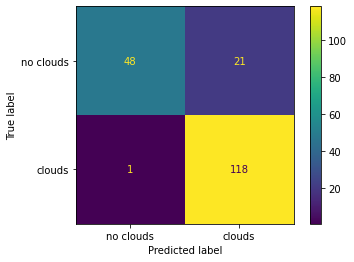

In [11]:
y_predict = (model_2.predict(X_test) > 0.5).astype("int32")
y_predict = np.squeeze(y_predict)
fig, ax = plt.subplots(1, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, labels=[0,1], ax=ax)
ax.set_xticklabels(['no clouds','clouds'])
ax.set_yticklabels(['no clouds','clouds'])

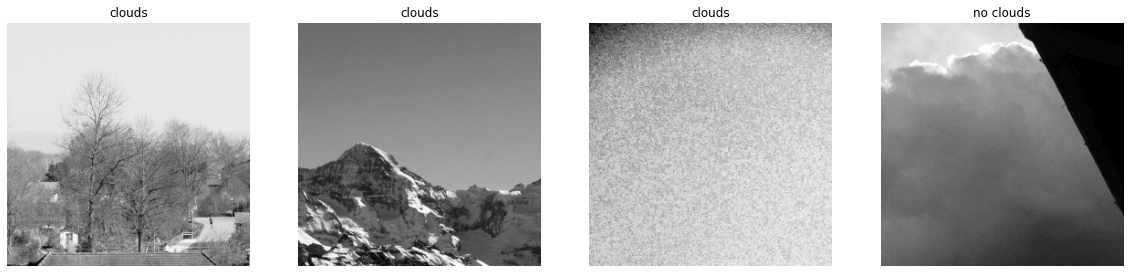

In [12]:
fig, ax = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.set_figheight(5)
i = 0
j = 0
while j < 3:
    if ((y_predict[i] == 1) & (y_test[i] == 0)):
        ax[j].imshow(X_test[i], cmap='Greys_r')
        ax[j].set_title('clouds')
        ax[j].axis('off')
        j += 1
    i += 1
i = 0
while j < 4:
    if ((y_predict[i] == 0) & (y_test[i] == 1)):
        ax[j].imshow(X_test[i], cmap='Greys_r')
        ax[j].set_title('no clouds')
        ax[j].axis('off')
        j += 1
    i += 1

Some misclassifications are actually due to the poor quality of the image, especially where areas of low contrast have been cropped.

**Cloud types**

Next, the model will try to recognize the 3 cloud types: cirrus, cumulus, and lenticularis. These types have been chosen because they are easy to recognize by eye.

This time the labels must be one-hot encoded and a stratification is not necessary:

In [13]:
## Prepare training and test data
X_cl = X[np.where(y<3)]
y_cl = y[np.where(y<3)]
y_cl = keras.utils.to_categorical(y_cl, 3)
X_train, X_test, y_train, y_test = train_test_split(X_cl, y_cl, 
                                                    test_size=0.2, 
                                                    random_state=123)

I will use a model with two convolutional layers trained over 10 epochs. This time the final classification layer must have 3 nodes with softmax activation.

In [14]:
model_3 = Sequential()

model_3.add(Conv2D(16, (5, 5), input_shape=X_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(Conv2D(16, (5, 5), input_shape=X_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(3, 3)))
model_3.add(Dropout(0.5))

model_3.add(Flatten())
model_3.add(Dense(128))
model_3.add(Activation('relu'))
model_3.add(Dense(128))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(3))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 262, 262, 16)      416       
_________________________________________________________________
activation_11 (Activation)   (None, 262, 262, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 258, 258, 16)      6416      
_________________________________________________________________
activation_12 (Activation)   (None, 258, 258, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 86, 86, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 86, 86, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 118336)           

In [15]:
model_3.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0003),
              metrics=['accuracy'])

model_3.fit(X_train, y_train,
            batch_size=15,
            epochs=10,
            validation_data=(X_test, y_test),
            shuffle=True)

Epoch 1/10
26/26 [==============================] - 17s 645ms/step - loss: 1.5368 - accuracy: 0.3588 - val_loss: 1.0926 - val_accuracy: 0.3789
Epoch 2/10
26/26 [==============================] - 16s 602ms/step - loss: 1.0966 - accuracy: 0.3668 - val_loss: 1.0886 - val_accuracy: 0.3684
Epoch 3/10
26/26 [==============================] - 15s 592ms/step - loss: 1.1024 - accuracy: 0.3879 - val_loss: 1.6860 - val_accuracy: 0.3579
Epoch 4/10
26/26 [==============================] - 16s 611ms/step - loss: 1.1265 - accuracy: 0.3905 - val_loss: 1.0820 - val_accuracy: 0.3579
Epoch 5/10
26/26 [==============================] - 15s 582ms/step - loss: 1.0866 - accuracy: 0.3668 - val_loss: 1.0838 - val_accuracy: 0.4000
Epoch 6/10
26/26 [==============================] - 16s 598ms/step - loss: 1.0644 - accuracy: 0.4169 - val_loss: 1.0636 - val_accuracy: 0.4632
Epoch 7/10
26/26 [==============================] - 16s 597ms/step - loss: 1.0292 - accuracy: 0.4987 - val_loss: 1.0646 - val_accuracy: 0.4316

An accuracy of 49% is reached, although with a lot of noise. Given how visually different the cloud types are, this is certainly not a satisfying result. The large difference between training accuracy and validation accuracy is an indication of a strong overfitting.

Let's have a look at the confusion matrix to see which category is easier to predict and which harder:

[Text(0, 0, 'cirrus'), Text(0, 1, 'cumulus'), Text(0, 2, 'lenticularis')]

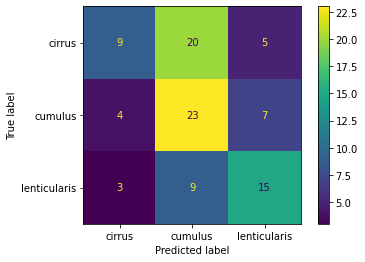

In [16]:
y_predict = np.argmax(model_3.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)
fig, ax = plt.subplots(1, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, labels=[0,1,2], ax=ax)
ax.set_xticklabels(categories[:-1])
ax.set_yticklabels(categories[:-1])

The model has difficulties in recognizing cirrus clouds, which are often classified as cumulus. The best predicted category is cumulus.

In conclusion, CNNs are suitable to recognize different types of clouds in pictures. However, a much larger training data set and better image quality would be needed to fully exploit the potential of the method. 